## GENERATIVE AI EMPOWERED SKIN CANCER DETECTION

In [ ]:
!pip install torch torchvision matplotlib


In [ ]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import pandas as pd
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# List files in the current directory
print("Files in current directory:", os.listdir())

# Construct the full path to the CSV file
# **VERIFY** this path is correct for your environment
file_path = os.path.join(current_directory, 'hmnist_28_28_RGB.csv')

# Check if the file exists
if os.path.exists(file_path):
    print("File found. Proceeding to load.")
    # Load the dataset
    dataset = pd.read_csv(file_path) # Load the data from the CSV file into a DataFrame

    X = dataset.iloc[:, :-1].values  # Now you can extract features
    y = dataset.iloc[:, -1].values   # and labels
else:
    print("File not found at:", file_path)
    print("Please check the file path and ensure the file exists.")

Current working directory: /content/Skin_Cancer_Detection_MNIST/Skin_Cancer_Detection_MNIST
Files in current directory: ['model.png', 'wsgi.py', 'model_architecture.png', 'best_model.h5', 'requirements.txt', 'README.md', 'Skin_Cancer_Detection.ipynb', '.git', 'Procfile', 'skin_cancer_detection.py', 'LICENSE', 'app.py', 'templates', 'tester.jpg', 'Skin_Cancer_Detection copy.ipynb']
File not found at: /content/Skin_Cancer_Detection_MNIST/Skin_Cancer_Detection_MNIST/hmnist_28_28_RGB.csv
Please check the file path and ensure the file exists.


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload the CSV file from your local machine


Saving hmnist_28_28_RGB.csv to hmnist_28_28_RGB.csv


In [ ]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
dataset = pd.read_csv('hmnist_28_28_RGB.csv')  # Use the exact filename as it appears after upload

# Extract features and labels
X = dataset.iloc[:, :-1].values  # Features (pixels)
y = dataset.iloc[:, -1].values   # Labels (classes)

# Reshape and normalize the images
X = X.reshape(-1, 3, 28, 28) / 255.0  # Assuming RGB images
y = torch.tensor(y, dtype=torch.long)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)

# DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 3, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x


In [ ]:
import torch.optim as optim

# Instantiate models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Ground truths and labels
        real_labels = torch.ones(imgs.size(0), 1).cuda()
        fake_labels = torch.zeros(imgs.size(0), 1).cuda()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_imgs = imgs.cuda()
        output = discriminator(real_imgs)
        loss_real = criterion(output, real_labels)

        z = torch.randn(imgs.size(0), 100).cuda()
        fake_imgs = generator(z)
        output = discriminator(fake_imgs.detach())
        loss_fake = criterion(output, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output = discriminator(fake_imgs)
        loss_G = criterion(output, real_labels)

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{num_epochs}] Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")


Epoch [0/200] Loss D: 0.18732696771621704, Loss G: 2.1800663471221924
Epoch [1/200] Loss D: 0.3519352972507477, Loss G: 3.7316808700561523
Epoch [2/200] Loss D: 0.042039904743433, Loss G: 5.913812160491943
Epoch [3/200] Loss D: 0.11251892894506454, Loss G: 8.462838172912598
Epoch [4/200] Loss D: 0.09859221428632736, Loss G: 6.340987682342529
Epoch [5/200] Loss D: 0.17655502259731293, Loss G: 8.761484146118164
Epoch [6/200] Loss D: 0.13778528571128845, Loss G: 10.614350318908691
Epoch [7/200] Loss D: 0.25684380531311035, Loss G: 3.945835590362549
Epoch [8/200] Loss D: 0.4523669481277466, Loss G: 5.132014751434326
Epoch [9/200] Loss D: 0.25199317932128906, Loss G: 7.01991605758667
Epoch [10/200] Loss D: 1.3011292219161987, Loss G: 5.498856067657471
Epoch [11/200] Loss D: 0.4309837818145752, Loss G: 8.574308395385742
Epoch [12/200] Loss D: 0.7005745768547058, Loss G: 8.365754127502441
Epoch [13/200] Loss D: 0.3040931224822998, Loss G: 4.5485968589782715
Epoch [14/200] Loss D: 4.6671562194

In [ ]:
import os
import torch
import torchvision

# Ensure the directory for generated images exists
os.makedirs("generated_images", exist_ok=True)

# Generate new images using the trained generator
with torch.no_grad():
    z = torch.randn(1000, 100).cuda()  # Generate 1000 new images
    generated_images = generator(z)
    for i, img in enumerate(generated_images):
        torchvision.utils.save_image(img, f"generated_images/img_{i}.png")


In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch


In [ ]:
def show_generated_images(images, num_images=16, cols=4):
    images = images[:num_images]
    grid_img = torchvision.utils.make_grid(images, nrow=cols, normalize=True, pad_value=1)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


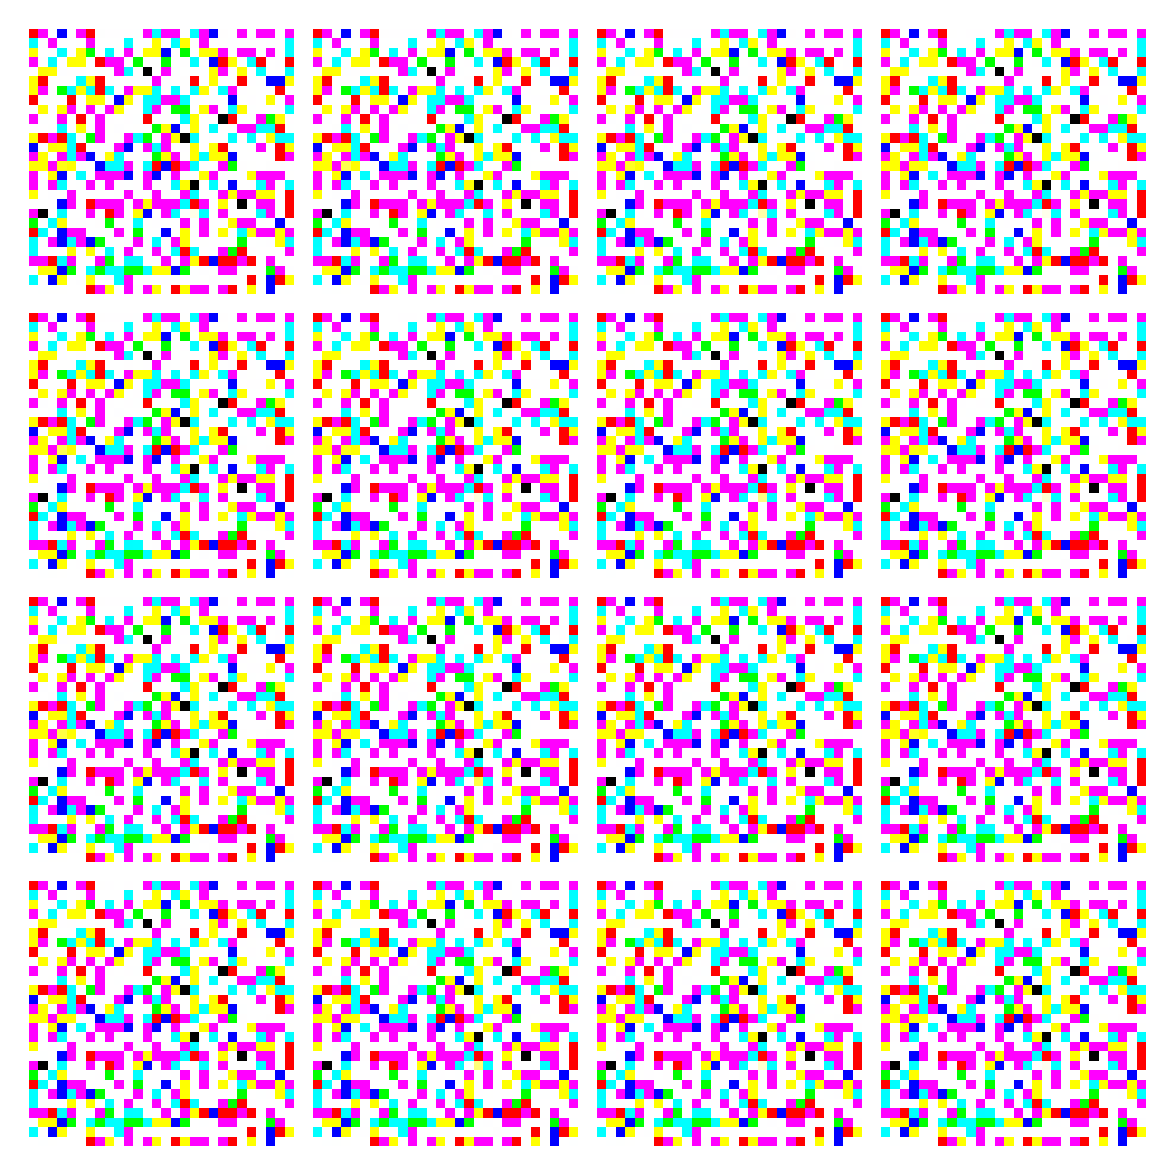

In [ ]:
# Generate random noise
z = torch.randn(16, 100).cuda()  # Generate 16 images for display

# Generate images from noise
generator.eval()  # Set generator to evaluation mode
with torch.no_grad():
    generated_images = generator(z)

# Move generated images to CPU for visualization
generated_images_cpu = generated_images.cpu()

# Display generated images
show_generated_images(generated_images_cpu)


In [ ]:
!zip -r generated_images.zip generated_images/


  adding: generated_images/ (stored 0%)
  adding: generated_images/img_588.png (stored 0%)
  adding: generated_images/img_114.png (stored 0%)
  adding: generated_images/img_405.png (stored 0%)
  adding: generated_images/img_351.png (stored 0%)
  adding: generated_images/img_964.png (stored 0%)
  adding: generated_images/img_182.png (stored 0%)
  adding: generated_images/img_353.png (stored 0%)
  adding: generated_images/img_578.png (stored 0%)
  adding: generated_images/img_35.png (stored 0%)
  adding: generated_images/img_527.png (stored 0%)
  adding: generated_images/img_253.png (stored 0%)
  adding: generated_images/img_430.png (stored 0%)
  adding: generated_images/img_280.png (stored 0%)
  adding: generated_images/img_440.png (stored 0%)
  adding: generated_images/img_172.png (stored 0%)
  adding: generated_images/img_690.png (stored 0%)
  adding: generated_images/img_224.png (stored 0%)
  adding: generated_images/img_649.png (stored 0%)
  adding: generated_images/img_163.png (sto

In [ ]:
from google.colab import files
files.download('generated_images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset

# Load the dataset from the CSV file
dataset_path = 'hmnist_28_28_RGB.csv'  # Use the correct path to your dataset
dataset = pd.read_csv(dataset_path)

# Extract features and labels
X = dataset.iloc[:, :-1].values  # All columns except the last one are features
y = dataset.iloc[:, -1].values   # The last column is the label

# Reshape X to match image dimensions (n_samples, channels, height, width)
X = X.reshape(-1, 3, 28, 28)  # Assuming 3 color channels (RGB) and 28x28 image size

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.long)

# Normalize the images (optional but recommended)
X_train /= 255.0  # Scale pixel values to [0, 1]


In [ ]:
desired_class_label = 0  # Set this to the desired class label for your generated images


In [ ]:
import torch
import torch.nn as nn

# Example generator model (modify according to your architecture)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28*3),  # Assuming RGB images with size 28x28
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 3, 28, 28)

# Initialize the generator
generator = Generator()

# Load pre-trained weights if available
# generator.load_state_dict(torch.load('path_to_generator_weights.pth'))

# If you have GPU available, move the model to CUDA
generator.cuda()


Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=2352, bias=True)
    (7): Tanh()
  )
)

In [ ]:
# Generate random noise vectors
z = torch.randn(16, 100).cuda()  # Adjust the size as needed

# Generate images using the generator model
generator.eval()  # Set the model to evaluation mode
with torch.no_grad():
    generated_images = generator(z)  # Generate images


In [ ]:
import os
import torchvision

# Create a directory to save generated images
os.makedirs('generated_images', exist_ok=True)

# Save each generated image to disk
for i, img in enumerate(generated_images):
    torchvision.utils.save_image(img, f'generated_images/img_{i}.png')


In [ ]:
!ls


 app.py			  model.png	    'Skin_Cancer_Detection copy.ipynb'	 tester.jpg
 best_model.h5		  Procfile	     Skin_Cancer_Detection.ipynb	 wsgi.py
 LICENSE		  README.md	     skin_cancer_detection.py
 model_architecture.png   requirements.txt   templates


In [ ]:
# Assuming your original dataset has labels from 0 to n-1 classes
your_desired_class_label = 0  # Replace with the class label for generated images

# Create labels for generated images
generated_labels = torch.full((num_new_images,), fill_value=your_desired_class_label, dtype=torch.long).cuda()

# Combine original and generated data
X_combined = torch.cat((X_train, generated_images.cpu()), dim=0)
y_combined = torch.cat((y_train, generated_labels.cpu()), dim=0)

# Create new DataLoader
from torch.utils.data import TensorDataset, DataLoader
combined_dataset = TensorDataset(X_combined, y_combined)
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)


In [ ]:
# Assuming you have original training data tensors: X_train, y_train

# Generate new images
num_new_images = 1000
z = torch.randn(num_new_images, 100).cuda()
with torch.no_grad():
    generated_images = generator(z)

# Create labels for generated images (you may choose appropriate labels or create synthetic ones)
# For example, assigning them to a specific class or distributing evenly
generated_labels = torch.full((num_new_images,), fill_value=your_desired_class_label, dtype=torch.long).cuda()

# Combine original and generated data
X_combined = torch.cat((X_train, generated_images.cpu()), dim=0)
y_combined = torch.cat((y_train, generated_labels.cpu()), dim=0)

# Create new DataLoader
from torch.utils.data import TensorDataset, DataLoader
combined_dataset = TensorDataset(X_combined, y_combined)
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)


In [ ]:
!ls


 app.py			  model.png			      skin_cancer_detection.py
 best_model.h5		  Procfile			      templates
 generated_images	  README.md			      tester.jpg
 hmnist_28_28_RGB.csv	  requirements.txt		      wsgi.py
 LICENSE		 'Skin_Cancer_Detection copy.ipynb'
 model_architecture.png   Skin_Cancer_Detection.ipynb


In [ ]:
!ls generated_images


img_0.png    img_229.png  img_358.png  img_487.png  img_615.png  img_744.png  img_873.png
img_100.png  img_22.png   img_359.png  img_488.png  img_616.png  img_745.png  img_874.png
img_101.png  img_230.png  img_35.png   img_489.png  img_617.png  img_746.png  img_875.png
img_102.png  img_231.png  img_360.png  img_48.png   img_618.png  img_747.png  img_876.png
img_103.png  img_232.png  img_361.png  img_490.png  img_619.png  img_748.png  img_877.png
img_104.png  img_233.png  img_362.png  img_491.png  img_61.png	 img_749.png  img_878.png
img_105.png  img_234.png  img_363.png  img_492.png  img_620.png  img_74.png   img_879.png
img_106.png  img_235.png  img_364.png  img_493.png  img_621.png  img_750.png  img_87.png
img_107.png  img_236.png  img_365.png  img_494.png  img_622.png  img_751.png  img_880.png
img_108.png  img_237.png  img_366.png  img_495.png  img_623.png  img_752.png  img_881.png
img_109.png  img_238.png  img_367.png  img_496.png  img_624.png  img_753.png  img_882.png
img_10.png  

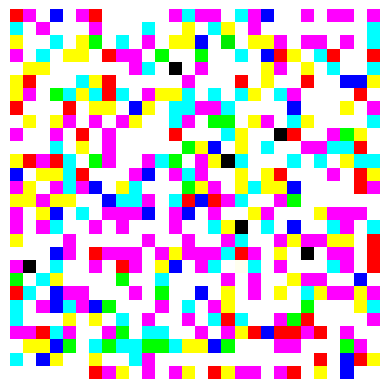

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the generated images folder
image_folder = 'generated_images'

# List of image files
images = os.listdir(image_folder)

# Load and display the first image as an example
img = Image.open(os.path.join(image_folder, images[0]))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
import os
from torchvision.utils import save_image

# Ensure class folders exist
class_label = '0'  # Replace with appropriate class label
class_folder = f'generated_images/class_{class_label}'
os.makedirs(class_folder, exist_ok=True)

# Assuming 'generated_images' contains only images
for i, image in enumerate(generated_images):
    image_path = os.path.join(class_folder, f'image_{i}.png')
    save_image(image, image_path)

# Now load the dataset using ImageFolder
generated_dataset = ImageFolder(root='generated_images/', transform=transform)


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load the generated images dataset
generated_dataset = ImageFolder(root='generated_images/', transform=transform)

# Combine the datasets (assuming `X_train` and `y_train` are tensors)
from torch.utils.data import ConcatDataset, TensorDataset, DataLoader

original_dataset = TensorDataset(X_train, y_train)
combined_dataset = ConcatDataset([original_dataset, generated_dataset])

# Create DataLoader
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load original dataset
original_dataset = TensorDataset(X_train, y_train)

# Load generated images dataset
generated_dataset = ImageFolder(root='generated_images/', transform=transform)

# Combine datasets
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([original_dataset, generated_dataset])

# Create DataLoader
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)
